# Linear Regression

revision: dcfbda7

In [1]:
import matplotlib.pyplot as plt
# PREAMBLE
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import check_grad

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2

In [2]:
# load all data
df = pd.read_csv('energy_summer_small.csv', sep=' ', index_col='Date')
df.index = pd.to_datetime(df.index)
print(df)

              energy       temp    weekday  season  non_working  split
Date                                                                  
2016-10-30  2.724000  22.222222     Sunday  summer  non-working  train
2014-10-27  2.935000  22.777778     Monday  summer      working     cv
2018-10-09  2.814042  22.777778    Tuesday  summer      working  train
2017-08-07  3.571519  25.555556     Monday  summer      working  train
2016-09-03  2.667000  20.000000   Saturday  summer  non-working  train
2018-09-28  2.934092  22.222222     Friday  summer      working     cv
2015-10-15  3.467000  25.833333   Thursday  summer      working  train
2014-08-24  3.012000  25.000000     Sunday  summer  non-working  train
2017-09-15  2.843882  23.888889     Friday  summer      working     cv
2014-09-10  3.924000  26.666667  Wednesday  summer      working  train
2018-09-06  3.069189  24.444444   Thursday  summer      working  train
2018-08-28  3.331804  26.111111    Tuesday  summer      working  train
2017-1

### Exploring the data

Before starting on any task, it is often useful to understand the data by visualizing it. In this example it can be done using a scatter plot since we only have two variables (temperature and load).

<AxesSubplot:xlabel='temp', ylabel='energy'>

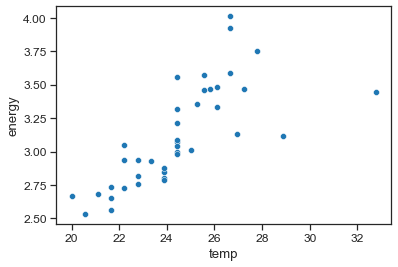

In [3]:
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, x='temp', y='energy', data=df)

### Feature Scaling

Scale the temperature column such that it has zero mean and unit variance. It is best not to overwrite `df['temp']`, but to create a new column `df['temp normalized']`.
Compare this to figure 1.4 on page 5.

In [7]:
df['temp normalized'] = (df['temp'] - df['temp'].mean()) / df['temp'].std()

<AxesSubplot:xlabel='temp normalized', ylabel='energy'>

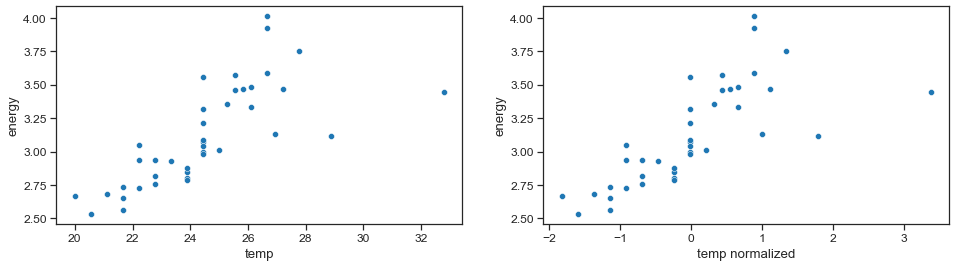

In [8]:
_, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.scatterplot(ax=ax[0], x='temp', y='energy', data=df)
sns.scatterplot(ax=ax[1], x='temp normalized', y='energy', data=df)

### Bias Term
In order to facilitate the vector notation $w^Tx$ we add a bias term to the vector $x$ i.e. an element with the value $1$.

In [9]:
# add bias term
df['bias'] = 1
print(df)

              energy       temp    weekday  season  non_working  split  \
Date                                                                     
2016-10-30  2.724000  22.222222     Sunday  summer  non-working  train   
2014-10-27  2.935000  22.777778     Monday  summer      working     cv   
2018-10-09  2.814042  22.777778    Tuesday  summer      working  train   
2017-08-07  3.571519  25.555556     Monday  summer      working  train   
2016-09-03  2.667000  20.000000   Saturday  summer  non-working  train   
2018-09-28  2.934092  22.222222     Friday  summer      working     cv   
2015-10-15  3.467000  25.833333   Thursday  summer      working  train   
2014-08-24  3.012000  25.000000     Sunday  summer  non-working  train   
2017-09-15  2.843882  23.888889     Friday  summer      working     cv   
2014-09-10  3.924000  26.666667  Wednesday  summer      working  train   
2018-09-06  3.069189  24.444444   Thursday  summer      working  train   
2018-08-28  3.331804  26.111111    Tue

In [10]:
# export pandas dataframe to numpy array
X = df[['bias', 'temp normalized']].values
y = df['energy'].values
m, n = X.shape

print(f"Dimensions X: {X.shape}, y: {y.shape}")

Dimensions X: (40, 2), y: (40,)


In [24]:
# Open mlis/regression/linearregression.py and implement the functions h and J.
from mlis.regression.linearregression import h, J

# test the hypothesis and cost function for w = [2,3]
w = np.array([2, 3])
# test the first 3 values calculated by h
np.testing.assert_array_almost_equal(h(w, X)[:3], [-0.76, -0.08, -0.08], decimal=2)
# test the correctness of J
np.testing.assert_array_almost_equal(J(w, X, y), 8.54, decimal=2)

Since $w$ is only two-dimensional, we can visualize $J(w)$ with a surface plot

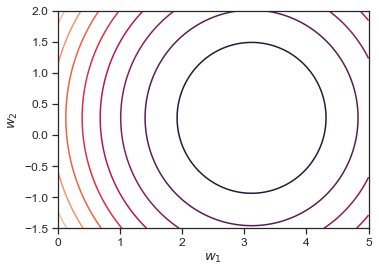

In [25]:
def plot_objective_contours(X, y, xlim=(0, 5), ylim=(-1.5, 2)):
    XX, YY = np.meshgrid(np.linspace(*xlim, 200), np.linspace(*ylim, 200))
    W = np.hstack([np.ravel(XX)[:, None], np.ravel(YY)[:, None]])
    ZZ = [J(w, X, y) for w in W]
    ZZ = np.array(ZZ).reshape(XX.shape)

    plt.contour(XX, YY, ZZ, levels=10)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("$w_1$")
    plt.ylabel("$w_2$")


plot_objective_contours(X, y)

### Implementing gradient descent

Now that we have the hypothesis and the cost function we can implement the gradient descent routine. First, write a function $\nabla J(w)$ which returns the gradient of the cost function. The gradient is just a vector with all the partial derivatives
$$
\nabla J(w) = \bigg(\frac{\partial J(w)}{\partial w_1} , \dotsc, \frac{\partial J(w)}{\partial w_n} \bigg)
$$
The gradient of the least squares objective is
$$
\nabla J(w) = \frac{2}{m}X^{\intercal}(Xw-y)
$$
when written in matrix-form (compare this to the script).

In [36]:
# Open mlis/regression/linearregression.py and implement the function dJ.
from mlis.regression.linearregression import dJ

# test the gradient for w = [2,3]
w = np.array([2, 3])
assert dJ(w, X, y).shape == (n,)  # we expect a vector of size (n,)
np.testing.assert_almost_equal(check_grad(J, dJ, w, X, y), 0.0, decimal=3)  # test the gradient

[-44.67708495 106.21883787]
[-44.67708495 106.21883787]


AssertionError: 
Arrays are not almost equal to 3 decimals
 ACTUAL: 109.47068688484377
 DESIRED: 0.0

Implement the gradient descent update rule
$$
w \leftarrow w - \eta \nabla J(w)
$$

In order to inspect the performance of the algorithm it is necessary to store the weights $w$ at each iteration $t = 1,\dots,iters$.

In [40]:
# Open mlis/regression/linearregression.py and implement the function gradientDescent

from mlis.regression.linearregression import gradientDescent

w0 = [1, 1]  # initial weights
eta = 0.05  # learning rate η
iters = 100  # number of iterations

ws = gradientDescent(dJ, X, y, w0, eta, iters)
# the last entry contains the final parameters found by gradient decent
print(f"best weights w: {ws[-1]}")

# testing the correctness of gradientDescent
np.testing.assert_array_almost_equal(ws[-1], [3.1168709, 0.27646542], decimal=4)  # test optimal weights

[  894.48958171 22104.66001133]
[ -1083101.8026362 -26772675.9693276]
[1.31182870e+09 3.24264599e+10]
[-1.58885726e+12 -3.92741951e+13]
[1.92438799e+15 4.75680173e+16]
[-2.33077523e+18 -5.76133072e+19]
[2.82298227e+21 6.97799352e+22]
[-3.41913231e+24 -8.45158800e+25]
[4.14117576e+27 1.02363723e+29]
[-5.01569846e+30 -1.23980627e+32]
[6.07490059e+33 1.50162533e+35]
[-7.35778226e+36 -1.81873466e+38]
[8.91157953e+39 2.20281030e+41]
[-1.07935037e+43 -2.66799404e+44]
[1.30728476e+46 3.23141406e+47]
[-1.58335375e+49 -3.91381566e+50]
[1.91772227e+52 4.74032505e+53]
[-2.32270186e+55 -5.74137453e+56]
[2.81320398e+58 6.95382304e+59]
[-3.40728907e+61 -8.42231326e+62]
[4.12683149e+64 1.02009154e+66]
[-4.99832501e+67 -1.23551181e+69]
[6.05385825e+70 1.49642398e+72]
[-7.33229626e+73 -1.81243489e+75]
[8.88071146e+76 2.19518017e+78]
[-1.0756117e+80 -2.6587526e+81]
[1.30275657e+83 3.22022104e+84]
[-1.57786931e+86 -3.90025892e+87]
[1.91107963e+89 4.72390544e+90]
[-2.31465645e+92 -5.72148747e+93]
[2.80345

d:\docs\uni\ws22\Introduction to Machine Learning\PM01\mlis\regression\linearregression.py:36: RuntimeWarning: overflow encountered in matmul
  grad = X.T@error


AssertionError: 
Arrays are not almost equal to 4 decimals

x and y +inf location mismatch:
 x: array([7.7204e+306,         inf])
 y: array([3.1169, 0.2765])

### Verifying Gradient Descent

A good way to verify that gradient descent is working correctly is to look at the values $J(w)$ and check that it is decreasing with each step.
Compare the following plot to figure 1.5 on page 6.

d:\docs\uni\ws22\Introduction to Machine Learning\PM01\mlis\regression\linearregression.py:21: RuntimeWarning: overflow encountered in square
  return 1/m * sum((X@w - y)**2)  # <<<--- Replace this by your own result.
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


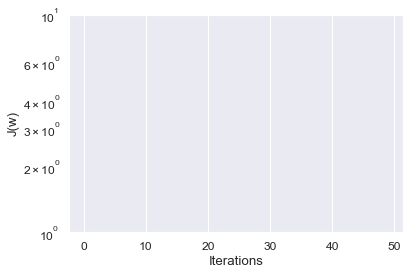

In [41]:
def plot_progress(costs, log=True):
    with sns.axes_style("darkgrid"):
        _, ax = plt.subplots()
        ax.plot(np.arange(len(costs)), costs, 'k')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('J(w)')
        if log:
            ax.set_yscale('log')
        return ax


plot_progress([J(w, X, y) for w in ws]);

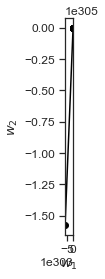

In [42]:
# show the path gradient descent took on the objective contours
plot_objective_contours(X, y)
plt.plot(ws[:, 0], ws[:, 1], '-ko');

Show the model that corresponds to the learned parameters.
Compare this to the plot in the lecture notes.

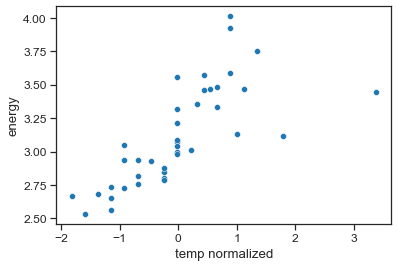

In [43]:
def plot_fit(h, w, normalized=True):
    outputs = 'energy'
    inputs = 'temp normalized' if normalized else 'temp'
    hue = None

    t = np.linspace(df[inputs].min(), df[inputs].max(), 100)
    x = np.vstack([np.ones(t.shape), t]).T  # add bias term
    yh = np.squeeze(h(w, x))

    _, ax = plt.subplots()
    sns.scatterplot(ax=ax, x=inputs, y=outputs, hue=hue, data=df)
    ax.plot(t, yh, 'k', label='Prediction')


plot_fit(h, ws[-1])

### Omitting Feature Scaling

Plot the objective and gradient descent progress without feature scaling.

[ 1014.48958171 25042.16001133]
[ -23546.53834598 -582070.01218193]
[  547338.87678267 13529370.82137332]
[-1.27220636e+07 -3.14470580e+08]
[2.95705928e+08 7.30941197e+09]
[-6.87325486e+09 -1.69896667e+11]
[1.59758828e+11 3.94900131e+12]
[-3.71336197e+12 -9.17888010e+13]
[8.63117068e+13 2.13349739e+15]
[-2.00619029e+15 -4.95900487e+16]
[4.66309800e+16 1.15264867e+18]
[-1.08386941e+18 -2.67916445e+19]
[2.51929706e+19 6.22732872e+20]
[-5.85574019e+20 -1.44745213e+22]
[1.36108177e+22 3.36439229e+23]
[-3.16363693e+23 -7.82004132e+24]
[7.35341465e+24 1.81765505e+26]
[-1.70919445e+26 -4.22487521e+27]
[3.97277431e+27 9.82010891e+28]
[-9.23413698e+28 -2.28254172e+30]
[2.14634105e+30 5.30543676e+31]
[-4.98885809e+31 -1.23317173e+33]
[1.15958762e+33 2.86632862e+34]
[-2.69529303e+34 -6.66236465e+35]
[6.26481725e+35 1.54856992e+37]
[-1.4561658e+37 -3.5994259e+38]
[3.38464594e+38 8.36634281e+39]
[-7.86711799e+39 -1.94463490e+41]
[1.82859734e+41 4.52002143e+42]
[-4.25030897e+42 -1.05061334e+44]
[9.8

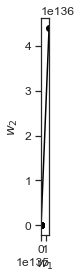

C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\matplotlib\ticker.py:2527: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\matplotlib\ticker.py:2357: RuntimeWarning: invalid value encountered in double_scalars
  return abs(x - np.round(x)) < atol
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\matplotlib\ticker.py:1174: RuntimeWarning: invalid value encountered in double_scalars
  coeff = round(b ** (fx - exponent))


ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 1 Axes>

In [44]:
X = df[['bias', 'temp', ]].values
y = df['energy'].values

# Try different values for eta and iters.
# With the following defaults, you will get numerical errors.
w0 = (4, 1)
ws = gradientDescent(dJ, X, y, w0, eta=0.001, iters=100)
print(f"calculated weights: {ws[-1]}")
print(f"optimal weights:    [ 0.3587, 0.1127]")

# plot objective contours
plot_objective_contours(X, y, xlim=[-1, 5], ylim=[-2, 2])

# plot only 100 weights
idx = np.linspace(0, len(ws) - 1, 100).astype(int)
plt.plot(ws[idx, 0], ws[idx, 1], '-ko')

# plot the objective values for the weights on a log scale
_, ax = plt.subplots()
ax.plot(idx, [J(w, X, y) for w in ws[idx, :]])
ax.set_yscale('log')

## Analytic Solution to Least Squares

We know that there exists a closed-form solution to linear regression which is given by
$$
w^{\star} = \big(X^TX \big)^{-1}X^Ty
$$
Using this formula does not require any feature scaling, and you will get an exact solution in one calculation: there is no "loop until convergence" like in gradient descent. However, it can only be used with the squared loss.

Important: In general, one should avoid calculating matrix inverses as this leads to numerical problems. Instead, use `np.linalg.solve` to solve the system of linear equations $X^TXw=X^Ty$.

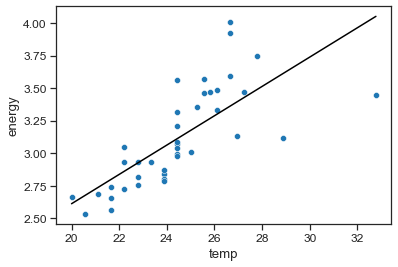

In [45]:
# Open mlis/regression/linearregression.py and implement the function least_squares

from mlis.regression.linearregression import least_squares

X = df[['bias', 'temp', ]].values
y = df['energy'].values
w = least_squares(X, y)

# testing the correctness of least_squares
np.testing.assert_array_almost_equal(least_squares(X, y), [0.3587, 0.1127], decimal=4)  # test optimal weights

# plot the model
plot_fit(h, w, normalized=False)

## Additional Features
We now use the additional input feature from the data set column `non_working`

In [ ]:
_, ax = plt.subplots()
sns.scatterplot(ax=ax, x='temp', y='energy', hue='non_working', data=df)

Create a column `df["is_workday"]`, which is `0` if the column `non_working` has entry `non-working` and 1` otherwise.

In [ ]:
# add the weekday column to our data frame
df["is_workday"] = True  # Your code here

In [ ]:
df["is_workday"] = (df["non_working"] == 'working') * 1

In [ ]:
# the scatter plot should look the same as above, just with a 0/1 legend
_, ax = plt.subplots()
sns.scatterplot(ax=ax, x='temp', y='energy', hue='is_workday', data=df)

Calculate the optimal weights for the model with the additional `non_working` feature using the closed-form solution.

In [ ]:
# insert your code here.
X = None
y = None
w = None
print(f"optimal weights w: {w}")
# expected is [0.28023641 0.25347537 0.10915125]

In [ ]:
X = df[['bias', 'is_workday', 'temp']].values
y = df['energy'].values
w = least_squares(X, y)

In [ ]:
np.testing.assert_almost_equal(least_squares(X, y), (0.2802, 0.2535, 0.1092), decimal=4)

Visualize the model fit by plotting the resulting predictions for both the weekend and weekday cases. Your plot should be identical to figure 2.2 on page 11

In [ ]:
# insert your code here.

In [ ]:
_, ax = plt.subplots()
sns.scatterplot(ax=ax, x='temp', y='energy', hue='is_workday', data=df)
t = np.linspace(df['temp'].min(), df['temp'].max(), 100)

# workday predictions
x = np.vstack([np.ones(t.shape), np.ones(t.shape), t]).T
y = np.squeeze(h(w, x))
plt.plot(t, y, 'r', label='Prediction')

# non-workday predictions
x = np.vstack([np.ones(t.shape), np.zeros(t.shape), t]).T
y = np.squeeze(h(w, x))

plt.plot(t, y, 'b', label='Prediction')

Create Features
$$
   x = \begin{bmatrix}
   \text{is_workday}\\
   1-\text{is_workday}\\
   \text{temp} \cdot \text{is_workday}\\
   \text{temp} \cdot (1-\text{is_workday})
   \end{bmatrix}
$$
and reproduce figure 2.3 on page 11.

In [ ]:
# insert your code here.

In [ ]:
X = np.vstack(
    (df['is_workday'], 1 - df['is_workday'], df['is_workday'] * df['temp'], (1 - df['is_workday']) * df['temp'])).T
y = df['energy'].values
w = least_squares(X, y)

_, ax = plt.subplots()
sns.scatterplot(ax=ax, x='temp', y='energy', hue='is_workday', data=df)
t = np.linspace(df['temp'].min(), df['temp'].max(), 100)

# workday predictions
x = np.vstack([np.ones(t.shape), t]).T
y = np.squeeze(h([w[0], w[2]], x))
plt.plot(t, y, 'r', label='Prediction')

# non-workday predictions
y = np.squeeze(h([w[1], w[3]], x))
plt.plot(t, y, 'b', label='Prediction')

# Loss Functions for Regression

The goal of this section is to compare the absolute and squared loss on a small data sets with an outlier.
First, we load the data a plot the squared loss result.

In [ ]:
df = pd.read_csv('energy_summer_small.csv', sep=' ', index_col='Date')
# add an outlier to the data set
df['outlier'] = 'normal'
outlier = pd.DataFrame(
    dict(
        Date='1900-01-01',
        temp=35,
        energy=2.7,
        outlier='outlier',
        weekday='Sunday',
        season='summer',
        non_working='working',
        split='train',
    ),
    index=[0]).set_index('Date')
df = pd.concat([df, outlier])

# normalize inputs
df['temp normalized'] = (df['temp'] - df['temp'].mean()) / df['temp'].std()
# add bias term
df['bias'] = 1

# data frame to matrix
X = df[['bias', 'temp normalized']].values
y = df['energy'].values

# run regression with squared loss
ws = gradientDescent(dJ, X, y, w0=np.zeros((2,)), eta=0.1, iters=100)
w_squared_loss = ws[-1]
plot_fit(h, w_squared_loss)

### Robust Regression

In [ ]:
# Open mlis/regression/robustregression.py and implement the functions J, dJ.
from mlis.regression.robustregression import J, dJ

w = np.array([2, 3])

# test the correctness of J
np.testing.assert_array_almost_equal(J(w, X, y), 2.27, decimal=2)

assert dJ(w, X, y).shape == (n,)  # we expect a vector of size (n,)
np.testing.assert_almost_equal(check_grad(J, dJ, w, X, y), 0.0, decimal=3)  # test the gradient

In [ ]:
# run regression with absolute loss loss
ws = gradientDescent(dJ, X, y, w0=np.zeros((2,)), eta=0.1, iters=100)
w_abs_loss = ws[-1]
plot_fit(h, w_abs_loss)